In [2]:
import numpy as np
from scipy.ndimage import label
from PIL import Image
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import torch

In [100]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3' #cannot work

In [457]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==-1]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [3]:
imagedir = Path('/home/data/kenya/images/')
maskdir = Path('/home/data/kenya/labels/')
buildingdir = Path('/home/data/kenya-binary-masks/buildings/')
cropsdir = Path('/home/data/kenya-binary-masks/crop_fields/')

In [553]:
mask = rioxarray.open_rasterio(cropsdir / 'kenol1_1001_f1.tif')

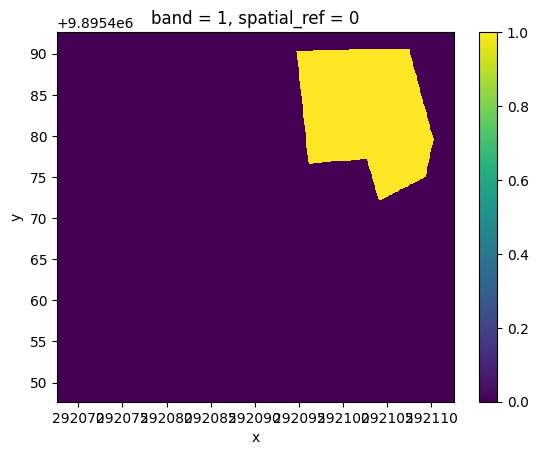

In [554]:
mask.plot()

In [555]:
mask_np = mask.to_numpy()

In [556]:
mask_np.shape

(1, 512, 512)

In [643]:
bool_mask = mask_np.astype(bool)

In [647]:
bool_mask.shape

(1, 512, 512)

In [720]:
def get_bounding_box(mask_array):
  # get bounding box from mask
  z, y_indices, x_indices = np.where(mask_array > 0)
  x_min, x_max = np.min(x_indices)+8, np.max(x_indices)-8
  y_min, y_max = np.min(y_indices)+8, np.max(y_indices)-8
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_point_grid(mask_array,bbox):
    points = []
    labels = []
    size=512
    step=16
    k=5
    x_min, y_min, x_max, y_max = bbox
    for i in range(1, int(size / step)):
        for j in range(1, int(size / step)):
            kernel = mask_array[:,max(0,j*step-k):min(512,j*step+k),max(0,i*step-k):min(512,i*step+k)]
            if kernel.max() == kernel.min():# and x_min<i*step<x_max and y_min<j*step<y_max:
                if kernel.max() == 0:
                    labels.append(-1)
                else:
                    labels.append(1)
                points.append([i*step,j*step])
    return points, labels

In [721]:
boxes = [get_bounding_box(mask_np)]
points, labels = get_point_grid(mask_np, boxes[0])

In [722]:
rawimg = Image.open(imagedir / 'kenol1_1001.tif').convert("RGB")

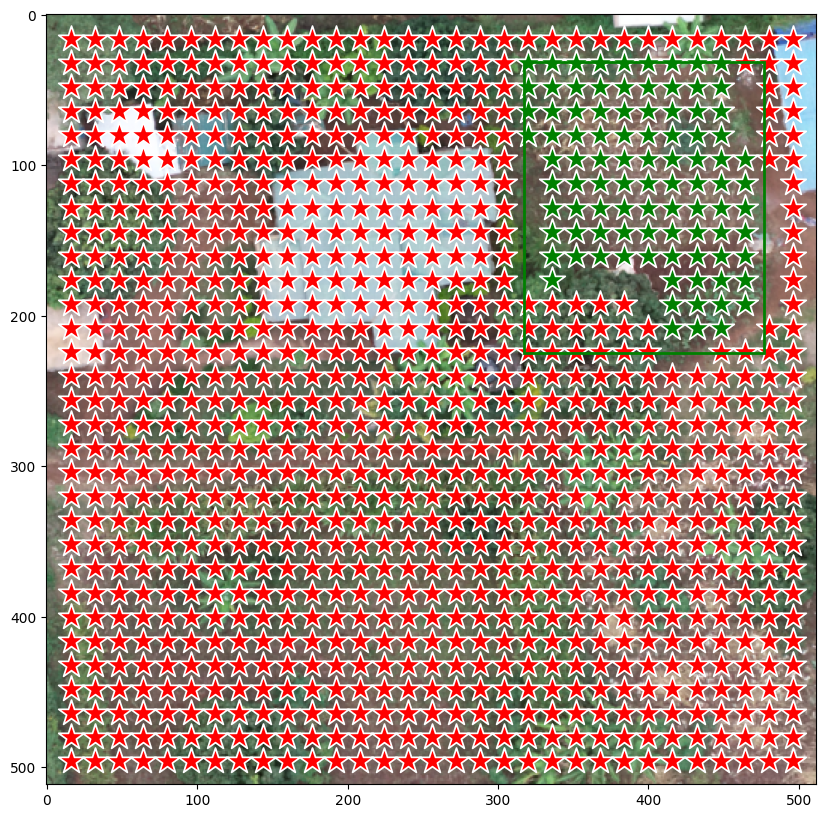

In [723]:
show_points_and_boxes_on_image(rawimg, boxes, points, labels)


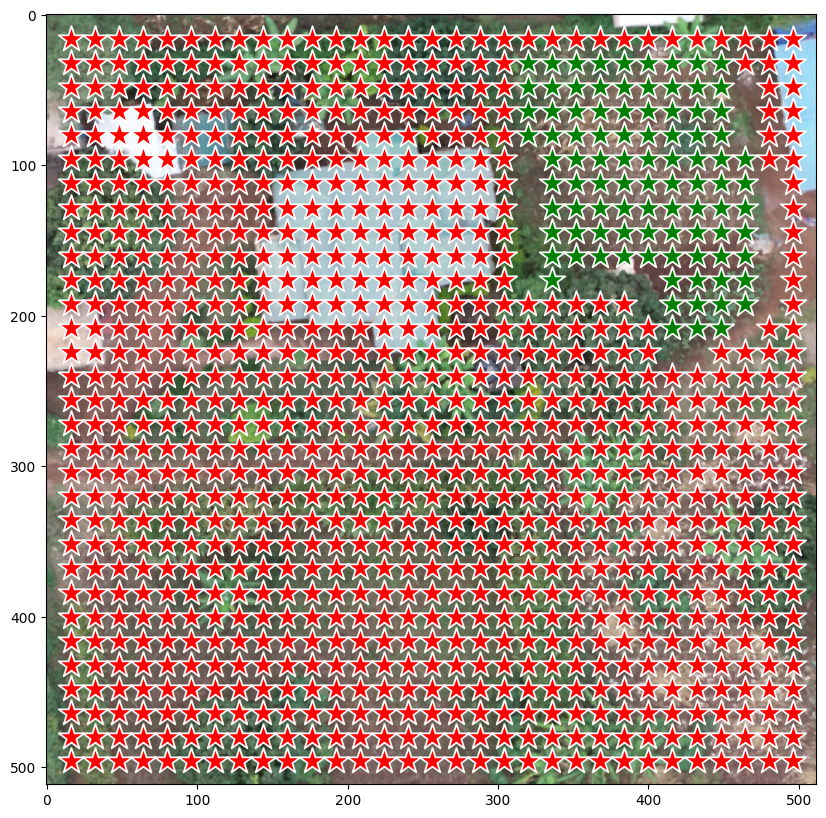

In [724]:
show_points_on_image(rawimg, points, labels)

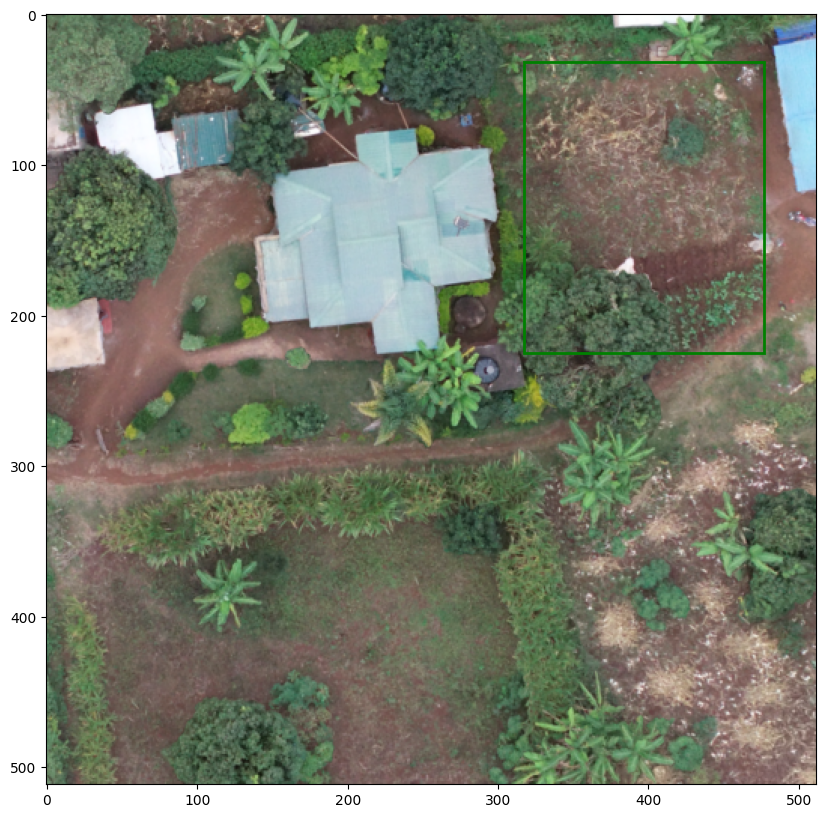

In [725]:
show_boxes_on_image(rawimg, boxes)

In [726]:
from transformers import SamModel, SamProcessor

In [727]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to(0)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [733]:
inputs = processor(rawimg,
                   input_boxes = [boxes],
                   #input_points = [points],
                   #input_labels = [labels],
                   #segmentation_maps = bool_mask,
                   return_tensors="pt").to(0)

In [734]:
with torch.no_grad():
    outputs = model(**inputs)

In [735]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [736]:
mask0 = masks[0].detach().cpu().numpy()

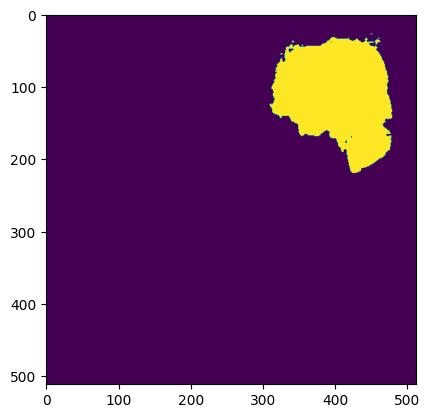

In [737]:
plt.imshow(mask0[0,0,:,:])

In [642]:
mask0

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa